# Topic Evaluation & Exploration

Evaluate topic assignment to Posts.

In [1]:
import os, sys, ast
sys.path.append("..")
from config import credentials
import dropbox

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import altair as alt
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
random_state = 23

## Loading

In [3]:
team_dbx = dropbox.DropboxTeam(credentials.dropbox_team_access_token)
team_root = team_dbx.with_path_root(dropbox.common.PathRoot.namespace_id(
    credentials.dropbox_team_namespace_id))
user_dbx = team_root.as_user(credentials.dropbox_team_member_id)

In [4]:
data_path = "/Data/CSVData"
model_path = "../models"
figures_path = "../reports/figures/"

In [5]:
topics40_fpath = os.path.join(data_path, "topics", "topics.csv")
_, res = user_dbx.files_download(topics40_fpath)
topics40 = pd.read_csv(res.raw)

posts_fpath = os.path.join(data_path, "PolPosts.csv")
_, res = user_dbx.files_download(posts_fpath)
posts = pd.read_csv(res.raw)

print("Topics n40", topics40.shape)
print("All Posts", posts.shape)

Topics n40 (22534, 4)
All Posts (27204, 23)


## Exploration

Topics

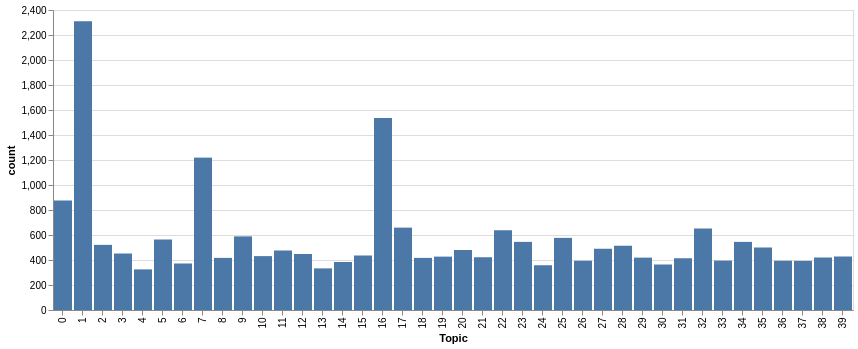

In [6]:
p_data = topics40.topic.value_counts().to_frame("count").rename_axis("Topic").reset_index()

chart = alt.Chart(p_data).mark_bar().encode(
    x="Topic:O",
    y="count:Q"
)

#chart.save(os.path.join(figures_path, "topics", "posts_per_topic.html"))
chart

Top-10 Posts per Topic

In [7]:
def get_top_10(df, topic, topic_range):
    topic_subset = df[df.topic == topic].copy()
    topic_subset.topic_distribution = topic_subset.topic_distribution.apply(ast.literal_eval)
    flattend_subset = pd.concat([topic_subset,
                                 pd.DataFrame(topic_subset.topic_distribution.values.tolist(),
                                              index=topic_subset.index, columns=topic_range)],
                                axis=1)
    return flattend_subset.sort_values(by=[topic], ascending=False).text.head(10)

In [8]:
topics40_top10_fp = "../reports/topics_40_top-10.txt"
topic_range = range(0, 40)

# with open(topics40_top10_fp, "w") as f:
#     for i in topic_range:
#         with pd.option_context("display.max_colwidth", -1):
#             f.write("Topic " + str(i) + ":\n" + get_top_10(topics40, i, topic_range).to_string(index=False) + "\n\n")

## Interactions per topic

In [9]:
data = posts.set_index("textID").join(topics40.set_index("textID"), lsuffix="_posts", rsuffix="_topics")
data.dropna(subset=["text_posts", "topic"], inplace=True)
data.drop_duplicates(subset=["text_posts"], keep="first", inplace=True)
data.topic = data.topic.apply(int)

In [10]:
grouped = data.groupby(["topic"]).agg({"interactionCount": ["count", "sum", "mean"]})
grouped

interactionCount                    
                 count     sum        mean
topic                                     
0                  876  180549  206.106164
1                 2310  879202  380.606926
2                  521  142128  272.798464
3                  452   62064  137.309735
4                  325   79746  245.372308
5                  564  130939  232.161348
6                  372   87524  235.279570
7                 1219  221796  181.949139
8                  417  133800  320.863309
9                  589  128693  218.494058
10                 431   63386  147.067285
11                 476  115553  242.758403
12                 448  199774  445.924107
13                 333   55743  167.396396
14                 384   88074  229.359375
15                 436   78303  179.594037
16                1536  169019  110.038411
17                 659  121036  183.666161
18                 417   92149  220.980815
19                 427   77720  182.014052
20                 480  204100  425.208333
21                 422  131814  312.355450
22                 638   95210  149.231975
23                 545   76939  141.172477
24                 358  256212  715.675978
25                 577   93081  161.318891
26                 394   66361  168.428934
27                 490  106738  217.832653
28                 514  440199  856.418288
29                 419   68540  163.579952
30                 364   58367  160.348901
31                 414   63435  153.224638
32                 652  156245  239.639571
33                 395   68136  172.496203
34                 545  139781  256.478899
35                 500  116562  233.124000
36                 394  100688  255.553299
37                 393  184696  469.964377
38                 420  152524  363.152381
39                 428  188490  440.397196

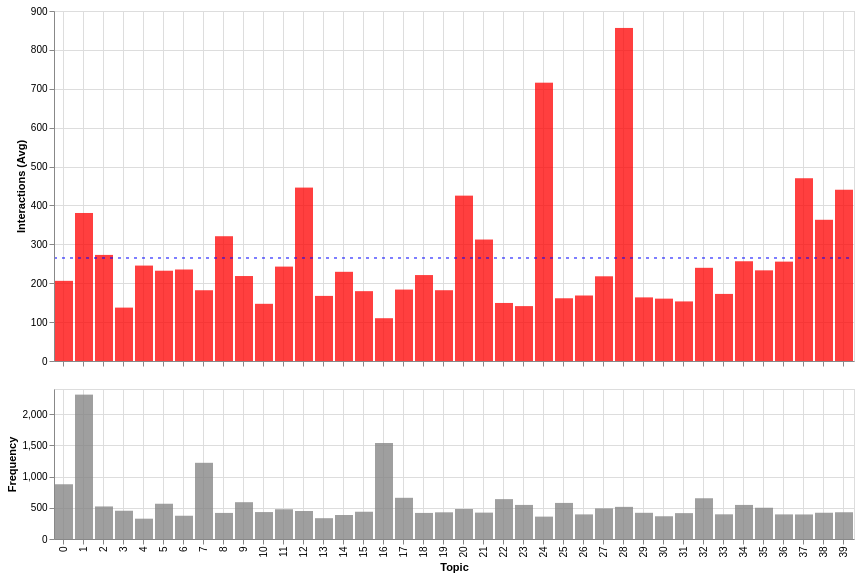

In [11]:
grouped.columns = ["count", "sum", "mean"]

freq_p = alt.Chart(grouped.reset_index()).mark_bar().encode(
    alt.X("topic:O", title="Topic", axis=alt.Axis(grid=True)),
    alt.Y("count:Q", title="Frequency"),
    color=alt.value("grey"),
    opacity=alt.value(0.75)
).properties(
    height=150
)

mean_p = alt.Chart(grouped.reset_index()).mark_bar().encode(
    alt.X("topic:O", title="", axis=alt.Axis(labels=False, grid=True)),
    alt.Y("mean:Q", title="Interactions (Avg)"),
    color=alt.value("red"),
    opacity=alt.value(0.75),
).properties(
    height=350
)

rule = alt.Chart(grouped).mark_rule(color="blue", strokeDash=[3,5]).encode(
    alt.Y("mean(mean):Q")
)

chart = alt.vconcat((mean_p + rule), freq_p)
#chart.save(os.path.join(figures_path, "topics", "interactions_per_topic.html"))
chart